<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [40]:
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [41]:
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [42]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

---
> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

En este problema se pide crear un modelo para conocer o predecir el comportamiento del clima a lo largo del tiempo. Para entender bien las características del problema, lo ideal es partir viendo cómo son los datos una vez que han sido facilitados:

In [45]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1


Se observa que cada día o dato tiene varios atributos como la temperatura media, la humedad, la velocidad del viento, la presión media y la fecha que ha sido modificada para poder añadirla como atributos. Además, se han convertido las temporadas del año en one-hot vectors para facilitar estos atributos a los algoritmos que se utilizarán posteriormente.

Para analizar con más detalle los datos, se contruyen boxplots con las temperaturas por año:

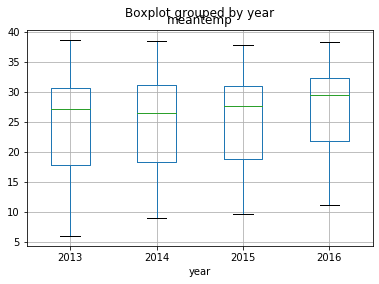

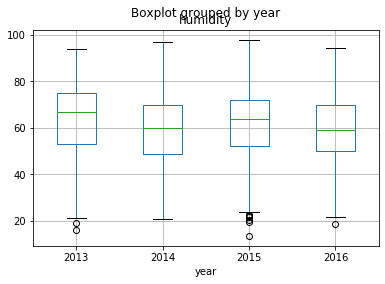

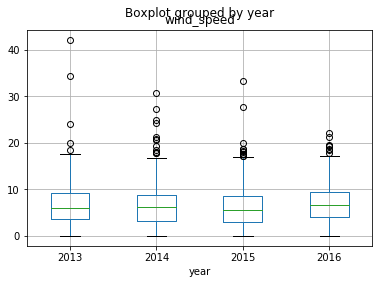

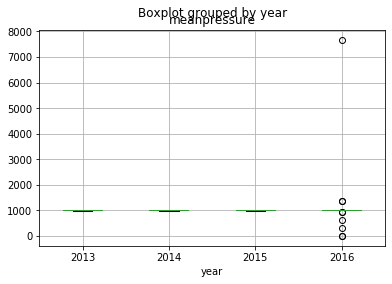

In [60]:
df.boxplot(column="meantemp", by="year")
df.boxplot(column="humidity", by="year")
df.boxplot(column="wind_speed", by="year")
df.boxplot(column="meanpressure", by="year")

Según los boxplots existen comportamientos similares en la mayoría de los años; sin embargo, se puede apreciar algunas situaciones irregulares, ya que algunos años presentan más outliers que otros y no necesariamente mejora con el avance. Las temperaturas tienen una tendencia similar aunque los valores se vuelven menos dispersos con el paso de los años. En el caso de la humedad estos varían su valor medio con el paso de los años y se presentan outliers en los años impares. La velocidad del viento es la más irregular; si bien su valores medios parecieran mantenerse, cada año tiene una gran cantidad de outliers superiores. Por último la presión media es la más constante, pero el 2016 tiene muchos datos irregulares, probablemente debido a un defecto del sensor.

Si se analiza desde el punto de vista de un gráfico:

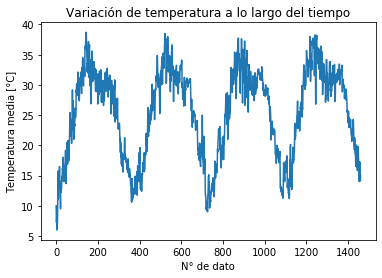

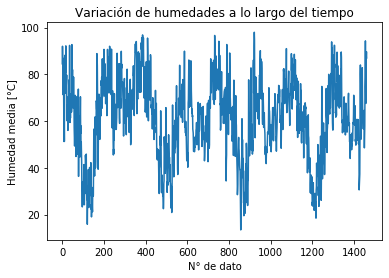

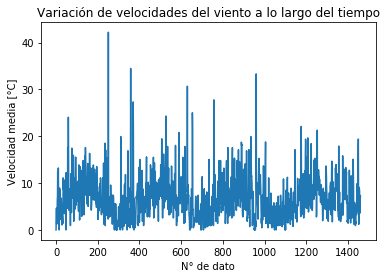

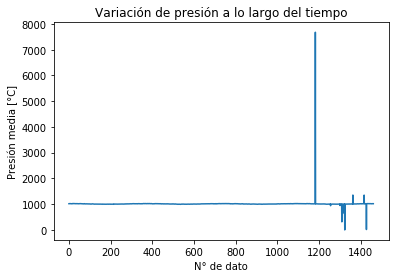

In [61]:
meantemps = X[:, 0]
plt.plot(meantemps)
plt.xlabel("N° de dato")
plt.ylabel('Temperatura media [°C]')
plt.title("Variación de temperatura a lo largo del tiempo")
plt.show()

humidities = X[:, 1]
plt.plot(humidities)
plt.xlabel("N° de dato")
plt.ylabel('Humedad media [°C]')
plt.title("Variación de humedades a lo largo del tiempo")
plt.show()

windspeeds = X[:, 2]
plt.plot(windspeeds)
plt.xlabel("N° de dato")
plt.ylabel('Velocidad media [°C]')
plt.title("Variación de velocidades del viento a lo largo del tiempo")
plt.show()

meanpresures = X[:, 3]
plt.plot(meanpresures)
plt.xlabel("N° de dato")
plt.ylabel('Presión media [°C]')
plt.title("Variación de presión a lo largo del tiempo")
plt.show()

En general se puede observar una tendencia que se repite cada año para cada característica; sin embargo también se pueden notar algunas anomalías. Por ejemplo, en el caso de la temperatura, el año 2013 se observa que hay más outliers en temperaturas bajas, lo que se puede comprobar en el gráfico ya que es el único año que tiene temperaturas bajo los 10° aproximadamente.

Considerar el día anterior para realizar predicciones podría no ser suficiente, ya que como se observa en los gráficos, los valores tienden a aumentar o disminuir en ciertos intervalos de tiempo (dependiendo de la temporada), pero no significa necesariamente que lo hace constantemente; una persona no podría decir con certeza que el día de mañana hará más calor porque ayer hizo más que anteayer, por ejemplo. La situación empeora cuando se quiere predecir si lloverá o no, pues las otras características no tienen un comportamiento tan marcada como la temperatura. La combinación de los atributos puede generar una variedad de casos que no se pueden predecir simplemente con el día anterior. Por tanto, hay que considerar mas fechas.

Algunos datos extras:

In [62]:
print("Cantidad de datos en los conjuntos de entrenamiento: ", X_train.shape[0])
print("Cantidad de datos en los conjuntos de validación", X_val.shape[0])
print("Record Temperatura máxima: ", np.amax(meantemps))
print("Record Temperatura mínima: ", np.amin(meantemps))
print("Record Humedad máxima: ", np.amax(humidities))
print("Record Humedad mínima: ", np.amin(humidities))
print("Record velocidades de viento máxima: ", np.amax(windspeeds))
print("Record velocidades de viento mínima: ", np.amin(windspeeds))
print("Record Presión máxima: ", np.amax(meanpresures))
print("Record Presión mínima: ", np.amin(meanpresures))

Cantidad de datos en los conjuntos de entrenamiento:  1000
Cantidad de datos en los conjuntos de validación 461
Record Temperatura máxima:  38.714285714285715
Record Temperatura mínima:  6.0
Record Humedad máxima:  98.0
Record Humedad mínima:  13.428571428571427
Record velocidades de viento máxima:  42.22
Record velocidades de viento mínima:  0.0
Record Presión máxima:  7679.333333333332
Record Presión mínima:  -3.0416666666666665


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

In [6]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor as Tree
from sklearn.model_selection import RandomizedSearchCV


def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

# Árbol no regularizado
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train, y_train)

# Árbol regularizado
# https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/fine-tuning-your-model?ex=11
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
params = {"max_depth": [3, None],
          "min_samples_split": randint(1, X_train.shape[0]),
          "min_samples_leaf": randint(1, X_train.shape[0])
         }

model_reg = Tree()
model_reg_cv = RandomizedSearchCV(model_reg, params, cv=5)
model_reg_cv.fit(X_train, y_train)

print("Mejores parámetros de regularización: {}".format(model_reg_cv.best_params_))
print("El mejor score es {}".format(model_reg_cv.best_score_))

Mejores parámetros de regularización: {'max_depth': 3, 'min_samples_leaf': 46, 'min_samples_split': 169}
El mejor score es 0.9089835718563585


**Comentarios:** Para la búsqueda de hiper-parámetros se utilizó el módulo RandomizedSearchCV de sklearn que se encarga de encontrarlos aleatoriamente. Los parámetros son encontrados mediante multiples cross-validations en base a los escogidos. Según este acercamiento, los hiper-parámetros pueden variar en cada ejecución.

Generalmente los arboles de decisión no necesitan escalamiento. El escalamiento puede ayudar en otros factores como visualización de resultados y comparación de rendimiento contra otros modelos. La razón principal de esto se debe a que los árboles de decisión son independiente al escalamiento de los atributos; el modelo es invariante ante cualquier transformación a estos. Técnicamente los nodos del árbol dividen los datos en 2 conjuntos mediante la comparación de cierto atributo con valores "limites", por tanto, este modelo solo trata de encontrar los mejores límites para cierto atributo que divida de mejor manera las muestras. Realizar escalamiento o no, siempre se elijiran límites similares, ya que la ordinalidad de las variables no cambian, esto es, la posición de atributo dentro del conjunto.

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```

En el caso de las predicciones con un árbol no regularizado:

RMSE train=  0.0
RMSE val=  2.3069899210786686


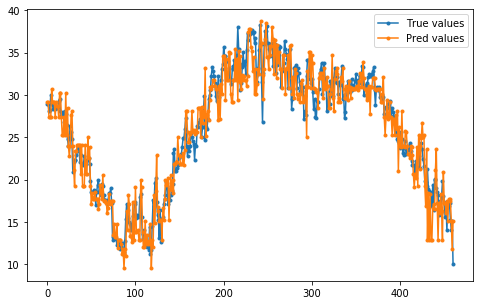

In [63]:
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()


En el caso de las predicciones con un árbol regularizado:

RMSE train=  2.060257231783583
RMSE val=  2.012497017614657


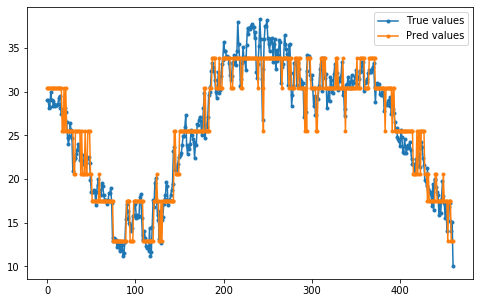

In [64]:
y_train_hat = model_reg_cv.predict(X_train)
y_val_hat = model_reg_cv.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

Tomando en cuenta las diferencias en las calidades de predicción vistas se esperaría que el comportamiento se extendiera al entrenar un ensamblador con estos tipos de árboles, es decir, las calidades de predicción se vean afectadas dependiendo si se regulariza o no.

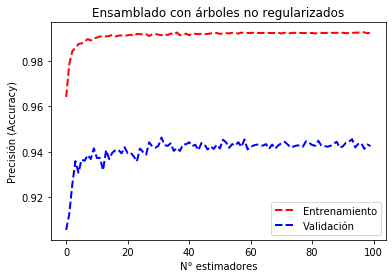

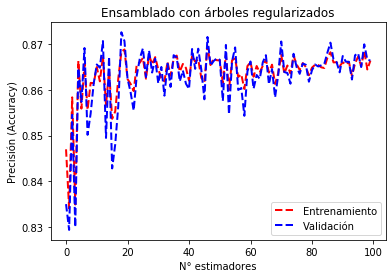

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.ensemble import BaggingRegressor


def accs_plot(title, train_accs, val_accs):
    plt.plot(train_accs, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
    plt.plot(val_accs, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
    #xi = list(range(len(depths)))
    #plt.xticks(xi, Cs)
    plt.title(title)
    plt.legend()
    plt.xlabel('N° estimadores')
    plt.ylabel('Precisión (Accuracy)')
    plt.show()
    
bre_unreg_train_accs = []
bre_unreg_val_accs = []
bre_reg_train_accs = []
bre_reg_val_accs = []

for i in range(100):
    # Ensamblador Bagging Regressor con árboles no regularizados
    bre_unreg = BaggingRegressor(base_estimator=Tree(), n_estimators=i+1, n_jobs=-1, oob_score=True)
    bre_unreg.fit(X_train, y_train)
    bre_unreg_train_accs.append(bre_unreg.score(X_train, y_train))
    bre_unreg_val_accs.append(bre_unreg.score(X_val, y_val))
    
    # Ensamblador Bagging Regressor con árboles regularizados
    bre_reg = BaggingRegressor(base_estimator=Tree(max_depth = 3, min_samples_leaf = 151, min_samples_split = 280), 
                                         n_estimators=i+1, n_jobs=-1, oob_score=True) 
    bre_reg.fit(X_train, y_train)
    bre_reg_train_accs.append(bre_reg.score(X_train, y_train))
    bre_reg_val_accs.append(bre_reg.score(X_val, y_val))

accs_plot("Ensamblado con árboles no regularizados", bre_unreg_train_accs, bre_unreg_val_accs)
accs_plot("Ensamblado con árboles regularizados", bre_reg_train_accs, bre_reg_val_accs)

Luego de entrenar varios ensambladores variando la cantidad de árboles utilizados, los resultados muestran que se cumple lo dicho anteriormente: la calidad de predicción es menor al utilizar árboles regularizados. Sin embargo es interesante notar lo que ocurre con la calidad del entrenamiento. Cuando se utilizan árboles no regularizados, el comportamiento de los accuracies del conjunto de validación 

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(base_estimator=Tree(...), n_estimators=...)
```

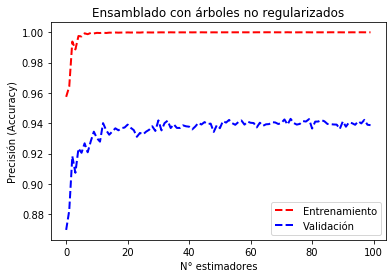

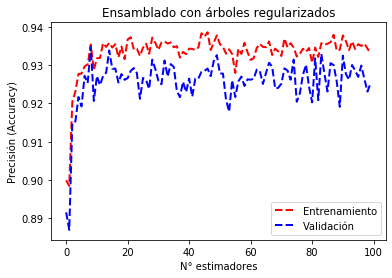

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
from sklearn.ensemble import AdaBoostRegressor

abre_unreg_train_accs = []
abre_unreg_val_accs = []
abre_reg_train_accs = []
abre_reg_val_accs = []

for i in range(100):
    # Ensamblador AdaBoostRegressor con árboles no regularizados
    abre_unreg = AdaBoostRegressor(base_estimator=Tree(), n_estimators=i+1)
    abre_unreg.fit(X_train, y_train)
    abre_unreg_train_accs.append(abre_unreg.score(X_train, y_train))
    abre_unreg_val_accs.append(abre_unreg.score(X_val, y_val))
    
    # Ensamblador AdaBoostRegressor con árboles regularizados
    abre_reg = AdaBoostRegressor(base_estimator=Tree(max_depth = 3, min_samples_leaf = 151, min_samples_split = 280), 
                                         n_estimators=i+1) 
    abre_reg.fit(X_train, y_train)
    abre_reg_train_accs.append(abre_reg.score(X_train, y_train))
    abre_reg_val_accs.append(abre_reg.score(X_val, y_val))

accs_plot("Ensamblado con árboles no regularizados", abre_unreg_train_accs, abre_unreg_val_accs)
accs_plot("Ensamblado con árboles regularizados", abre_reg_train_accs, abre_reg_val_accs)

**Comentarios:**

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

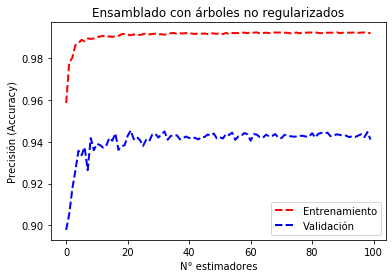

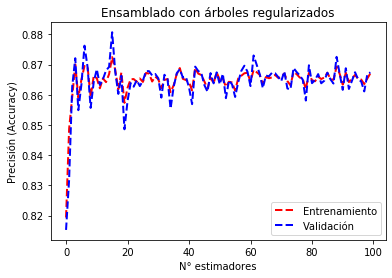

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestRegressor


rfre_unreg_train_accs = []
rfre_unreg_val_accs = []
rfre_reg_train_accs = []
rfre_reg_val_accs = []

for i in range(100):
    rfre_unreg = RandomForestRegressor(n_estimators=i+1, n_jobs=-1, oob_score=True)
    rfre_unreg.fit(X_train, y_train)
    rfre_unreg_train_accs.append(rfre_unreg.score(X_train, y_train))
    rfre_unreg_val_accs.append(rfre_unreg.score(X_val, y_val))
    
    rfre_reg = RandomForestRegressor(max_depth = 3, min_samples_leaf = 151, min_samples_split = 280, 
                                         n_estimators=i+1, oob_score=True) 
    rfre_reg.fit(X_train, y_train)
    rfre_reg_train_accs.append(rfre_reg.score(X_train, y_train))
    rfre_reg_val_accs.append(rfre_reg.score(X_val, y_val))

accs_plot("Ensamblado con árboles no regularizados", rfre_unreg_train_accs, rfre_unreg_val_accs)
accs_plot("Ensamblado con árboles regularizados", rfre_reg_train_accs, rfre_reg_val_accs)

**Comentarios:**

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

In [11]:
# Ensamblador BaggingRegressor
bre_unreg_oob_error = bre_unreg.oob_score_
bre_unreg_val_error = bre_unreg.score(X_val, y_val)
bre_reg_oob_error = bre_reg.oob_score_
bre_reg_val_error = bre_reg.score(X_val, y_val)

print("OOB error para modelo ensamblado con Bagging con árboles no regularizados: ", bre_unreg_oob_error)
print("Val error para modelo ensamblado con Bagging con árboles no regularizados: ", bre_unreg_val_error)
print("OOB error para modelo ensamblado con Bagging con árboles regularizados: ", bre_reg_oob_error)
print("Val error para modelo ensamblado con Bagging con árboles regularizados: ", bre_reg_val_error)

print("-------------------------------------------------------------------------------------------------")

# Ensamblado con RandomForest
rfre_unreg_oob_error = rfre_unreg.oob_score_
rfre_unreg_val_error = rfre_unreg.score(X_val, y_val)
rfre_reg_oob_error = rfre_reg.oob_score_
rfre_reg_val_error = rfre_reg.score(X_val, y_val)

print("OOB error para modelo ensamblado con RandomForest con árboles no regularizados: ", rfre_unreg_oob_error)
print("Val error para modelo ensamblado con RandomForest con árboles no regularizados: ", rfre_unreg_val_error)
print("OOB error para modelo ensamblado con RandomForest con árboles regularizados: ", rfre_reg_oob_error)
print("Val error para modelo ensamblado con RandomForest con árboles regularizados: ", rfre_reg_val_error)

OOB error para modelo ensamblado con Bagging con árboles no regularizados:  0.9439850991394595
Val error para modelo ensamblado con Bagging con árboles no regularizados:  0.9424691443404044
OOB error para modelo ensamblado con Bagging con árboles regularizados:  0.8615200336981014
Val error para modelo ensamblado con Bagging con árboles regularizados:  0.8664394523852145
-------------------------------------------------------------------------------------------------
OOB error para modelo ensamblado con RandomForest con árboles no regularizados:  0.9429606420995018
Val error para modelo ensamblado con RandomForest con árboles no regularizados:  0.9410520644790995
OOB error para modelo ensamblado con RandomForest con árboles regularizados:  0.8619154734743979
Val error para modelo ensamblado con RandomForest con árboles regularizados:  0.8674179007131577


**Comentarios:**

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

In [12]:
from sklearn.preprocessing import QuantileTransformer

rfre_unreg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rfre_unreg.fit(X_train, y_train)

# Con quintiles
def combine_predictions_q(predictions):
    pred = np.array(predictions)
    q = []
    
    for i in range(pred.shape[1]):
        vals = pred[:, i]
        mean = np.mean(vals)
        
        if mean < 20:
            quantile = np.quantile(vals, 0.25)
            
        elif mean < 30:
            quantile = np.quantile(vals, 0.75)
        
        else:
            quantile = np.quantile(vals, 0.5)
            
        q.append(quantile)
        
    return q

# Con mediana
def combine_predictions(predictions):
    pred = np.array(predictions)
    medians = []
    
    for i in range(pred.shape[1]):
        median = np.median(pred[:, i])
        medians.append(median)
    
    return medians

list_estimators = rfre_unreg.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]

new_predictions = combine_predictions(list_predictions)
new_predictions_q = combine_predictions_q(list_predictions)

print("RMSE val (mean) = ", RMSE(y_val, new_predictions))
print("RMSE val (quantile) = ", RMSE(y_val, new_predictions_q))

RMSE val (mean) =  1.683793827515854
RMSE val (quantile) =  1.80543577323161


**Comentarios:**

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```

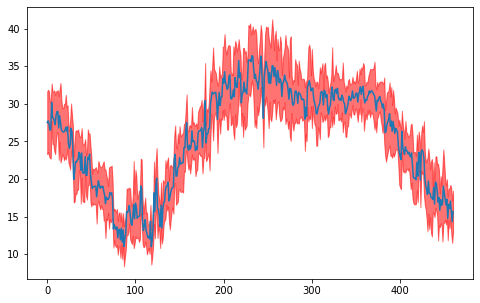

In [13]:
rfre_unreg = RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True)
rfre_unreg.fit(X_train, y_train)
list_estimators = rfre_unreg.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]

X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

**Comentarios:**

>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

Primero cargar el dataset correspondiente:

In [15]:
df = pd.read_csv("DailyDelhiClimateTest.csv")

df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
y = df.pop("y_value").values
X = df.values

df.head()

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_summer,season_winter
0,15.913043,85.869565,2.743478,59.000000,6,2017,1,0,1
1,18.500000,77.222222,2.894444,1018.277778,0,2017,1,0,1
2,17.111111,81.888889,4.016667,1018.333333,1,2017,1,0,1
3,18.700000,70.050000,4.545000,1015.700000,2,2017,1,0,1
4,18.388889,74.944444,3.300000,1014.333333,3,2017,1,0,1


In [16]:
rfre_unreg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rfre_unreg.fit(X_train, y_train)

#rfre_unreg.score(X, y)
print(df.head())
print(y.shape)
print(X.shape)
print(X_train.shape)
print(X_train[1])
print(X[1])

    meantemp   humidity  wind_speed  meanpressure  cday  year  month  \
0  15.913043  85.869565    2.743478     59.000000     6  2017      1   
1  18.500000  77.222222    2.894444   1018.277778     0  2017      1   
2  17.111111  81.888889    4.016667   1018.333333     1  2017      1   
3  18.700000  70.050000    4.545000   1015.700000     2  2017      1   
4  18.388889  74.944444    3.300000   1014.333333     3  2017      1   

   season_summer  season_winter  
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  
(112,)
(112, 9)
(1000, 11)
[3.512500e+01 2.500000e+01 6.962500e+00 1.001375e+03 6.000000e+00
 2.015000e+03 5.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
 0.000000e+00]
[1.85000000e+01 7.72222222e+01 2.89444444e+00 1.01827778e+03
 0.00000000e+00 2.01700000e+03 1.00000000e+00 0.00000000e+00
 1.00000000e+00]


<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.

---
### Importante
* Esta pregunta será evaluada **sólo** por los resultados (*submission*) obtenidos en el desafío presentado en __[Kaggle](https://www.kaggle.com/c/t1-ml/)__ a través del siguiente __[link](https://www.kaggle.com/t/91f8c0c746f945cfa510b88469df4d67)__. Las notas serán entregadas a través de la siguiente fórmula:  
$$ Nota(i) = 100\cdot max\left(0.55; s^{(1-i)} \right), \ \ con \ \ i \in \{1,\ \ldots, N\}$$
Con la escala de decaimiento es $ s = 1.05$ y con $i$ su lugar en el *ranking*.

* La métrica de evaluación será el *f1 score* [[3]](#refs) sobre la clase positiva (*harassment*), así evaluar la calidad del modelo sobre la clase minoritaria, lo cual también debiera reflejar el desempeño de la clase negativa (al ser el complemento).
```python
from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')
```

* El archivo de *submission* debe contener las predicciones de *harassment* (0 o 1) a cada dato de pruebas, además de la columna de *id* asociado al dato, iniciando en 1. Si leyó de manera ordenada el archivo de pruebas, se puede generar de la siguiente manera:
```python
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)
```

* Se solicita realizar **un solo** *submission* por grupo, para no perjudicar la nota de sus compañeros en el *ranking*. Además de ser claros con sus nombres de entrega para no asignarles de manera errónea su correspondiente nota.

* **Si no realiza *submission* a Kaggle su nota en esta sección será de 0**.

* **Si su *score* alcanzado es menor o igual al *benchmark* random que se encuentra en el *ranking*, su nota en esta sección será de 25**

Primero es necesario abrir los archivos:

In [17]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re
import string
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
df_train = pd.read_csv("Train_data.csv")
df_test = pd.read_csv("Test_input.csv")

Un poco de ilustración para entender los dataset:

In [18]:
df_train.sample(5, random_state=1)

,id,tweet_content,harassment,IndirectH,PhysicalH,SexualH
4668,9614,apologies and and and but on at pm headlines t...,0,0,0,0
4589,9421,literally haven t slept hours really t co Tfpq...,0,0,0,0
2954,4879,With no cable we ve been looking for fun nurse...,0,0,0,0
669,8341,RT InkedbettiePDX This would be hilarious if t...,0,0,0,0
4856,9263,mature boobs japanese france large ellen sain...,1,0,0,1


In [19]:
df_test.sample(5, random_state=1)

,id,tweet_content
1547,1548,she needs a new set of knee pads
851,852,the mkr family of products from makes it easie...
302,303,mkr music lifestyle presents el vuitto acayi s...
108,109,juney junes and baza are loving the dishes ton...
1361,1362,you are ltleans in closer to web cam that s of...


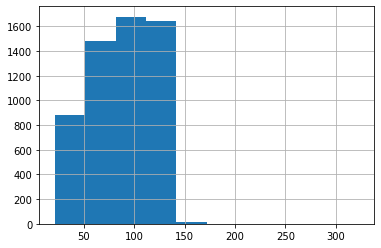

In [20]:
tweets = df_train.tweet_content.str.len()
tweets.hist()

**Comentarios:** Se puede observar que la distribución de palabras por tweet tiene sentido porque el máximo permitido por la plataforma es 140. Sin embargo, la cantidad de palabras utilizadas podría ser significativo para indicar si existe acoso en el tweet.

Para entender mejor cuales son las palabras que significan acoso se hace una nube de palabras:

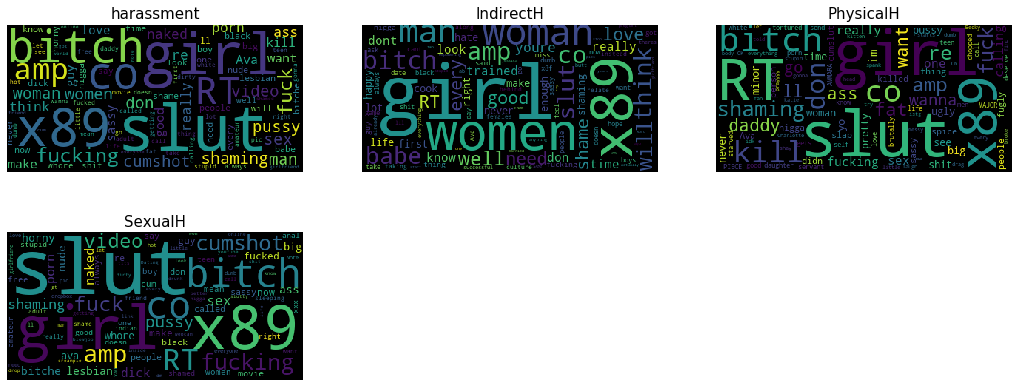

In [21]:
list_classes = list(df_train.columns[2:].values)
plt.figure(figsize=(18,7))

for i in range (1,5):
    plt.subplot(2, 3, i)
    subset = df_train[df_train[df_train.keys()[i+1]] == 1]
    text = subset.tweet_content.values
    cloud_i = WordCloud(background_color='black',
                        collocations=False,
                        max_words = 100
                       ).generate(" ".join(text))
    
    plt.axis('off')
    title = list_classes[i-1]
    plt.title(title,fontsize=15)
    plt.imshow(cloud_i)

plt.show()

**Comentarios:** Es interesante notar la frecuencia con la cual aparecen las palabras en tweets clasificados como ofensivos. Para el enfoque de la tarea interesa "harassment", donde se puede apreciar también que hay palabras sin ningún significado léxico como "x89" o "RT", lo que sería prudente limpiarlas del texto.

A continuación se definen funciones importantes para la limpieza y preparación de los textos.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def clean_text(text):
    """ Preparación de texto."""
    # 1. Lowercases
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Borrar caracteres especiales
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    clean = clean.replace(b"x89", b" ")
    clean = clean.replace(b"RT", b" ")
    # 3. Contradicciones
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Puntuaciones
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Números (un número no es una amenaza)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Espacios extras
    clean = re.sub(b'\s+', b' ', clean)
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Agregación de signos para la separación de palabras
    clean = re.sub(b" ", b"# #", clean)
    clean = b"#" + clean + b"#"

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Función para encontrar las ocurrencias de una expresión regular"""
    return len(re.findall(regexp, text))

def char_analyzer(text):
    """ Separador de text en pequeños samples."""
    tokens = text.split()
    return [token[i: i + 3] for token in tokens for i in range(len(token) - 2)]

def get_indicators_and_clean_comments(df):
    """
    Contenido extra para enfatizar si el tweet corresponde a un acoso.
    """
    # Numero de saltos de línea (\n)
    df["ant_slash_n"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\n", x))
    # Largo de palabras y caracteres
    df["raw_word_len"] = df["tweet_content"].apply(lambda x: len(x.split()))
    df["raw_char_len"] = df["tweet_content"].apply(lambda x: len(x))
    # Número de mayúsculas
    df["nb_upper"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"[A-Z]", x))
    # Número de palabras similares a f..k
    df["nb_fk"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"[Ff]\S{2}[Kk]", x))
    # Número de palabras S...
    df["nb_sk"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    # Número de palabras D...
    df["nb_dk"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    # Número de veces que se usa "you"
    df["nb_you"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x))
    # Número de veces que se usa la palabra motherf...
    df["nb_mother"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    # Número de palabras racistas
    df["nb_ng"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    # Sentencias que partan con dos puntos (:)
    df["start_with_columns"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"^\:+", x))
    # Ver si hay algún timestamp
    df["has_timestamp"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    # Ver si hay alguna fecha y tiempo
    df["has_date_long"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
    # Ver si solo hay una fecha
    df["has_date_short"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))
    # Ver si hay algún enlace
    df["has_http"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    # Ver si hay un correo
    df["has_mail"] = df["tweet_content"].apply(
        lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x)
    )
    # Palabras entre comillas
    df["has_emphasize_equal"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\={2}.+\={2}", x))
    df["has_emphasize_quotes"] = df["tweet_content"].apply(lambda x: count_regexp_occ(r"\"{4}\S+\"{4}", x))

    # Limpieza de comentarios
    df["clean_comment"] = df["tweet_content"].apply(lambda x: clean_text(x))

    # Nuevo largo de palabras y caracteres
    df["clean_word_len"] = df["clean_comment"].apply(lambda x: len(x.split()))
    df["clean_char_len"] = df["clean_comment"].apply(lambda x: len(x))
    # Número de palabras únicas en el tweet
    # La palabra f..k reduce la cantidad de palabras usadas en el tweet
    df["clean_chars"] = df["clean_comment"].apply(lambda x: len(set(x)))
    df["clean_chars_ratio"] = df["clean_comment"].apply(lambda x: len(set(x))) / df["clean_comment"].apply(
        lambda x: 1 + min(99, len(x)))


In [23]:
# Reemplazo de patronces
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

In [24]:
get_indicators_and_clean_comments(df_train)
get_indicators_and_clean_comments(df_test)

In [25]:
# TD-IDF para obtener atributos
train_text = df_train['clean_comment']
test_text = df_test['clean_comment']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

# Nuevamente TF-IDF para las letras dentro de una palabra
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    tokenizer=char_analyzer,
    analyzer='word',
    ngram_range=(1, 1),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

Luego de haber limpiado los tweets y vectorizarlos, falta entrenar un modelo. En este caso, como es un problema desbalanceado, algunos modelos como los de aprendizaje supervisado pueden ser muy sensibles a los datos. Sin embargo, algunos ensabladores suelen trabajar bien con este tipo de problemas. Para esto se utilizará un ensamblador tipo Bagging que clasificará los tweets si es que son acoso o no. Se utilizará un modelo especial brindado por la libreria imblearn, que es especial para problemas de balanceo y en este caso el ensamblador utilizará árboles de decisión no regularizados, debido al buen rendimiento comprobado en la sección 1.

In [26]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# Creación del clasificador. Se utilizan árboles de decisiones no regularizados.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

train_target = df_train["harassment"]
y_train = train_target
X_train = train_features

# Entrenamiento y predicción.
bbc.fit(X_train, y_train)
preds = bbc.predict(test_features)

Using TensorFlow backend.


Finalmente se crea el archivo para la submission en Kaggle.

In [27]:
submission = pd.DataFrame.from_dict({'id': df_test['id']})
submission['harassment'] = preds

submission.to_csv('submission.csv', index=False)

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18